## Importing necessary libraries and dependencies

In [1]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#NRC Emotion Lexicon
#from nrclex import NRCLex


## Reading and Loading the Dataset

In [2]:
!pip install unzip

In [3]:
!unzip /content/drive/MyDrive/trainingandtestdata.zip

Archive:  /content/drive/MyDrive/trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: testdata.manual.2009.06.14.csv  
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)


,target,ids,date,flag,user,text
757779,0,2295468503,Tue Jun 23 07:58:05 PDT 2009,NO_QUERY,miamii,just rang orange to upgrade my phone and they ...
1283154,4,2001914293,Tue Jun 02 02:30:46 PDT 2009,NO_QUERY,sweetcupcake,realized i am such a &quot;visual&quot; person...
1257485,4,1997714825,Mon Jun 01 17:19:55 PDT 2009,NO_QUERY,mikeheth,@danamhuff My grading policy is on the bottom ...
1262224,4,1998780640,Mon Jun 01 19:06:46 PDT 2009,NO_QUERY,KateMB,@krisalderson It does depend on the guy singin...
1506168,4,2072514462,Sun Jun 07 21:10:29 PDT 2009,NO_QUERY,sjtimmermann,"@acfoss13, me either! on a fun note, i saw han..."


## Exploratory Data Analysis

In [5]:
#Top few records of data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#Columns/features in data
print(df.columns)

#Length of dataset
print('length of data is', len(df))

#Shape of data
print(df.shape)

#Data information
df.info()

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
length of data is 1600000
(1600000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
#Datatypes of all columns
print('Dataset of all columns:' , df.dtypes)

#Checking for Null values
print('null values:', np.sum(df.isnull().any(axis=1)))

Dataset of all columns: target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object
null values: 0


### Data Visualization of Target Variables

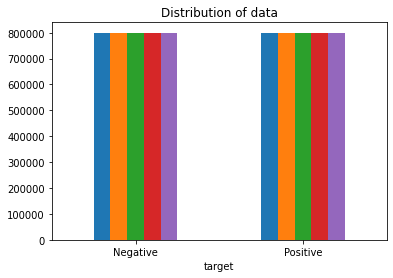

In [9]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

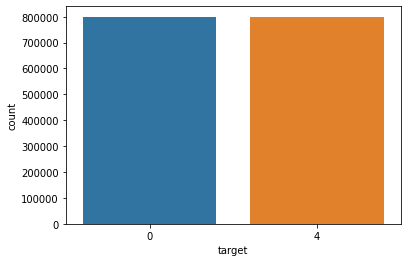

In [10]:
import seaborn as sns
sns.countplot(x='target', data=df)

##  Data Preprocessing
Before training the model, we need to perform various pre-processing steps on the dataset, such as removing stopwords, removing emojis, etc. The text document is then converted into the lowercase for better generalization.

Subsequently, the punctuations are needed to be cleaned and removed thereby reducing the unnecessary noise from the dataset. After that, we also have to remove the repeating characters from the words along with removing the URLs as they do not have any significant importance.

Lastly, we perform Stemming(reducing the words to their derived stems) and Lemmatization(reducing the derived words to their root form known as lemma) for better results.

In [11]:
#Selecting the text and Target column for our further analysis
data=df[['text','target']]



In [12]:
#Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data['target'] = data['target'].replace(4,1)

#Print unique values of target variables
data['target'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([0, 1])

In [13]:
#Separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [14]:
#taking one fourth data so we can run on our machine easily

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

### Count Vectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(data.text)
neg_doc_matrix = cvec.transform(data[data.target == 0].text)
pos_doc_matrix = cvec.transform(data[data.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],
                            columns=cvec.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,negative,positive,total
to,313176,252704,565880
the,257869,266003,523872
my,190846,125983,316829
it,157225,147544,304769
and,153968,149635,303603
you,103842,198194,302036
is,128452,109876,238328
in,115445,101115,216560
for,98986,117362,216348
of,92717,91087,183804


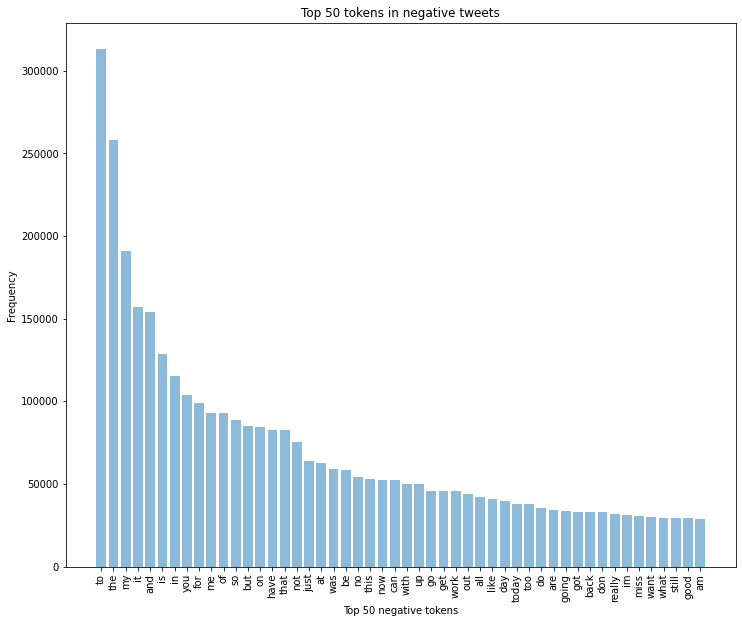

In [16]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='negative',ascending=False)       
                                  ['negative'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='negative',ascending=False) 
                                     ['negative']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')
plt.savefig('top_negative_tokens.png')

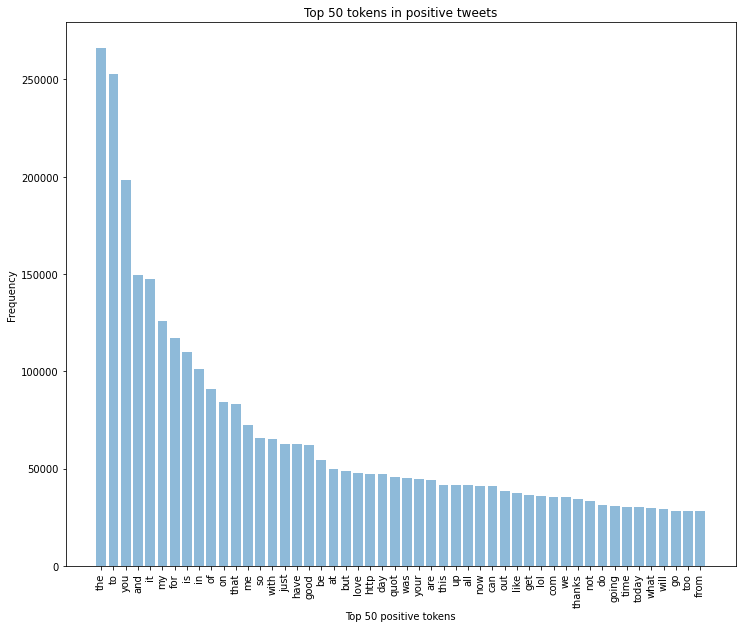

In [17]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='positive',ascending=False)       
                                  ['positive'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='positive',ascending=False) 
                                     ['positive']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')
plt.savefig('top_positive_tokens.png')

In [18]:
#Combining positive and negative tweets

dataset = pd.concat([data_pos, data_neg])

#Making statement text in lower case

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [19]:
#Defining stopwords list containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [20]:
#Cleaning and removing the above stop words list from the tweet text

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [21]:
#Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [22]:
#Cleaning and removing repeating characters

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [23]:
#Cleaning and removing URL’s

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [24]:
#Cleaning and removing Numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [25]:
#Getting tokenization of tweet text

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [26]:
#Applying Stemming

import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [27]:
#Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [28]:
#Separating input feature and label

X=data.text
y=data.target

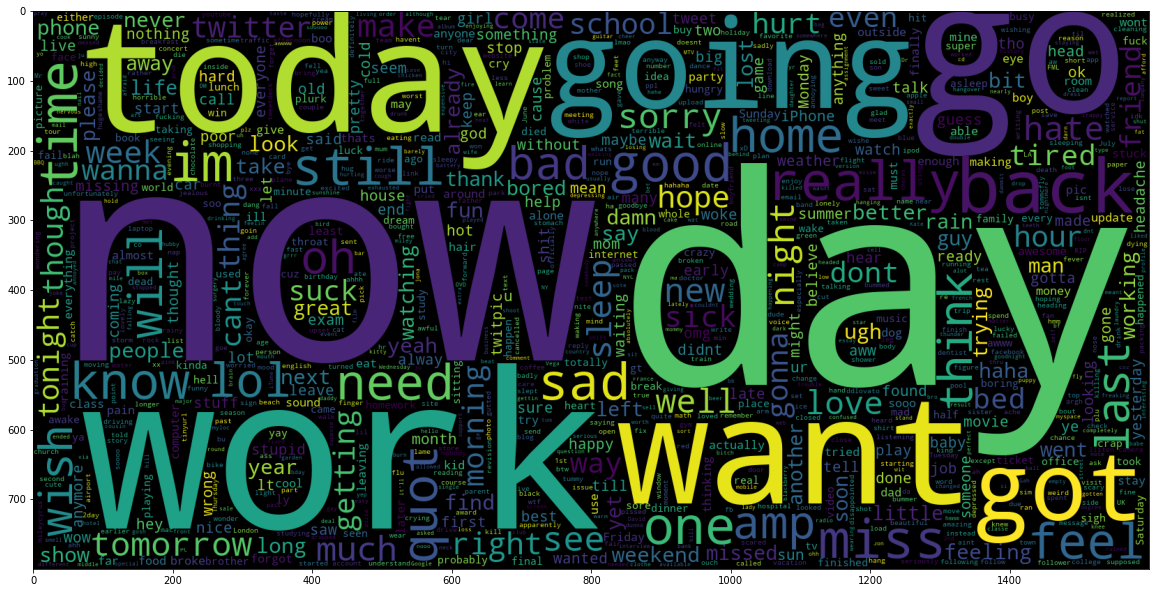

In [29]:
#Plot a cloud of words for negative tweets

data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.savefig('word_cloud_negative.png')

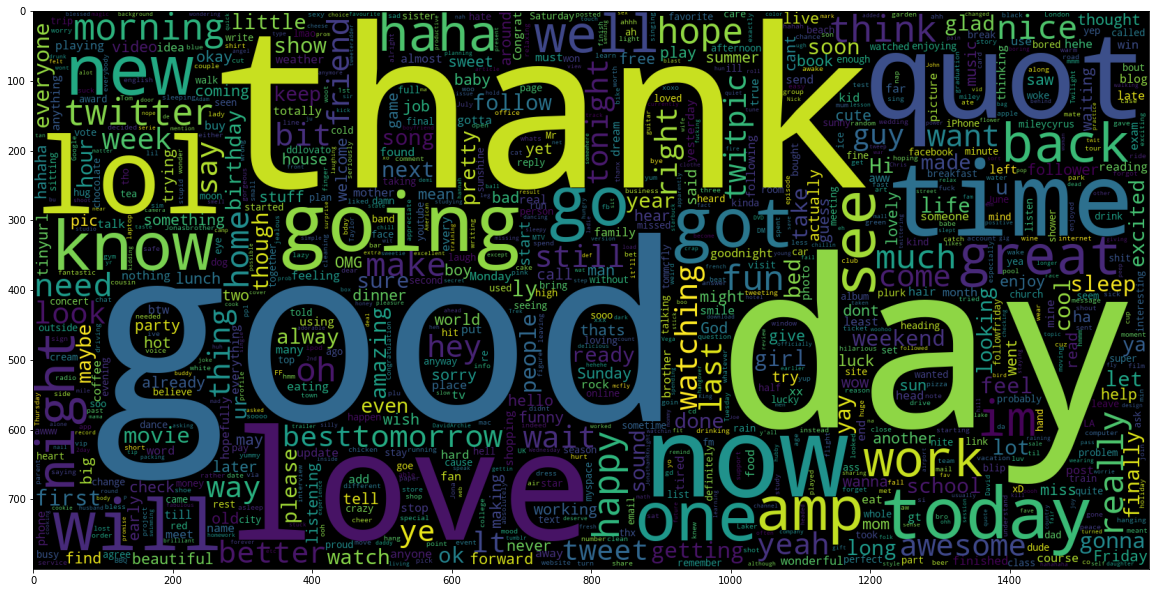

In [30]:
#Plot a cloud of words for positive tweets

data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)
plt.savefig('word_cloud_positive.png')

## Splitting our data into Train and Test Subset

In [31]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

## Transforming Dataset using TF-IDF Vectorizer

In [32]:
#Fit the TF-IDF Vectorizer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [33]:
#Transform the data using TF-IDF Vectorizer

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Function For Model Evaluation
After training the model we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively :

Accuracy Score
Confusion Matrix with Plot
ROC-AUC Curve

In [34]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


## Model Building
In the problem statement we have used three different models respectively :

Bernoulli Naive Bayes
SVM (Support Vector Machine)
Logistic Regression
The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models and then try to find out the one which gives the best performance among them.

#### Bernoulli Naive Bayes Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



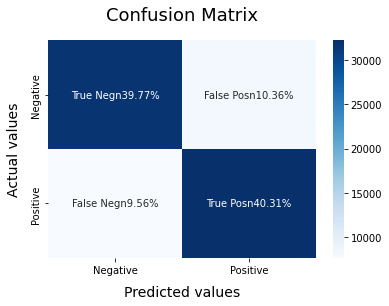

In [35]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

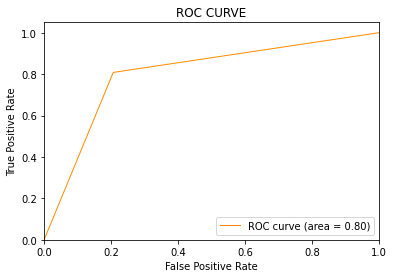

In [36]:
#Plot the ROC-AUC Curve for BNB

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Support Vector Machine

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



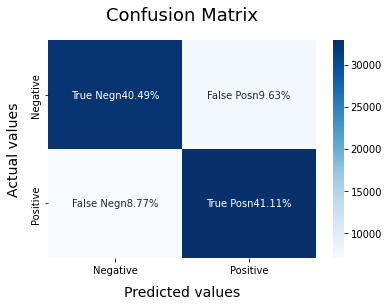

In [37]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

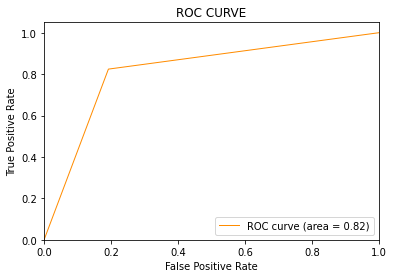

In [38]:
#Plot the ROC-AUC Curve for SVM

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



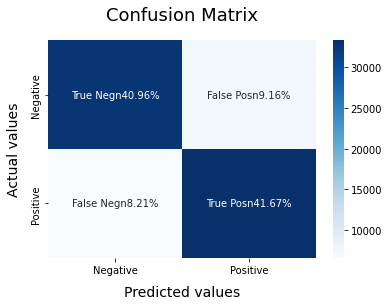

In [39]:
#Logistic Regression

LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

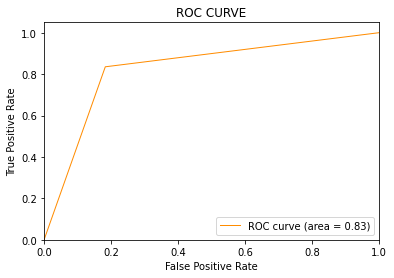

In [40]:
#Plot the ROC-AUC Curve for Logistic Regression

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Conclusion
Upon evaluating all the models we can conclude the following details i.e.

Accuracy: As far as the accuracy of the model is concerned Logistic Regression performs better than SVM which in turn performs better than Bernoulli Naive Bayes.

